This notebook provides a few example dynamical systems to try out SINDy on.

One of the biggest challenges in applying SINDy is dealing with measurement noise. As we saw earlier in the semester, differentiation by finite differences performs very badly with even just a little bit of noise, so some kind of smoothing is necessary. Here you can try out SINDy on some noisy trajectories.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def FitzHughNagumoRHS(t, X, eps):
    """
    eps controls the stiffness of the system (i.e. separation of timescales in oscillation)
    """
    x, y = X
    dx = eps + x - x**3 / 3 - y
    dy = eps * (x - y)
    return np.array([dx, dy])


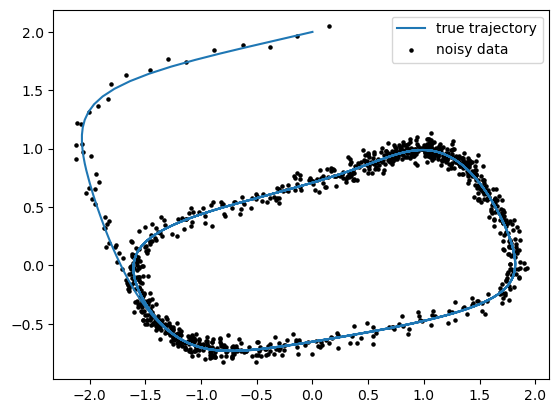

In [86]:
# compute a trajectory from the FitzHugh-Nagumo system and add noise
eps = 0.2
x0 = np.array([0, 2])

tspan = (0, 100)
nt = 1000
t_eval = np.linspace(*tspan, nt)

res = solve_ivp(FitzHughNagumoRHS, tspan, x0, t_eval=t_eval, args=(eps,))

measurement_noise_level = 5e-2
noisy_data = res.y + np.random.randn(*res.y.shape)*measurement_noise_level

plt.plot(res.y[0], res.y[1], label='true trajectory')
plt.scatter(noisy_data[0], noisy_data[1], 5, c='k', label='noisy data')
plt.legend()

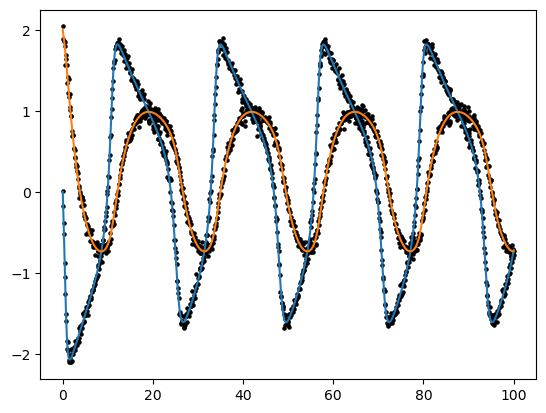

In [3]:
plt.plot(res.t, res.y.T);
plt.scatter(res.t, noisy_data[0], 5, c='k')
plt.scatter(res.t, noisy_data[1], 5, c='k')

In [88]:

def LotkaVolterraRHS(t, X, delta, gamma, K):
    """
    K = prey carrying capacity
    delta = predator benefit from predation
    gamma = predator death rate
    """
    x, y = X
    return np.array([x*(1-x/K) - y*x/(1+x), delta*y*x/(1+x) - gamma*y])

delta, gamma, K = 0.9, 0.2, 2
x0 = np.array([1,1])

tf = 1000
Nt = 5000
tspan = (0, tf)
t_eval = np.linspace(*tspan, Nt)

res = solve_ivp(LotkaVolterraRHS, tspan, x0, t_eval=t_eval, args=(delta,gamma,K))

measurement_noise_level = 5e-2
noisy_lv_data = res.y + np.random.randn(*res.y.shape)*measurement_noise_level

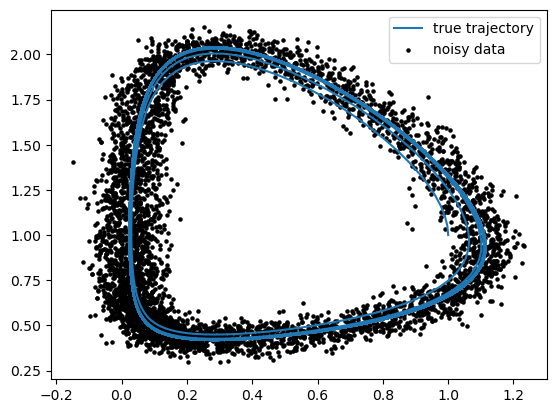

In [89]:
plt.plot(res.y[0], res.y[1], label='true trajectory')
plt.scatter(noisy_lv_data[0], noisy_lv_data[1], 5, 'k', label='noisy data')
plt.legend()

## Distinguishing candidate models

Next we'll look at a case where there are multiple models that could fit the data. Suppose that the true system obeys the differential equations:
$$
{dx \over dt} = -y + (1-(x^2 + y^2))x\\
{dy \over dt} = x + (1-(x^2+y^2))y
$$

This system has a limit cycle on the circle $x^2+y^2=1$, which happens to be the same as the solution to the simple harmonic oscillator:
$$
{dx \over dt} = -y\\
{dy \over dt} = x
$$

If you only observe data on the limit cycle, is it possible to learn that the "true" equations contain extra terms? What data would you need to distinguish these two models from each other?

In [90]:
def stable_limit_cycle(t, X):
    x, y = X
    k = 1-x**2-y**2
    dx = -y + k*x
    dy = x + k*y
    return np.array([dx, dy])

x0 = np.array([0,1])
tf = 10
Nt = 200
tspan = (0, tf)
t_eval = np.linspace(*tspan, Nt)
dt = t_eval[1]-t_eval[0]

res = solve_ivp(stable_limit_cycle, tspan, x0, t_eval=t_eval, method='DOP853', atol=1e-9)

circle_data = res.y.T

In [91]:
def sparsifyDynamics(Theta,dXdt,lamb,n):
    """
    Carries out the sequentially thresholded least squares algorithm

    INPUT:
        Theta : (Nt, m) array giving the values of the dictionary of candidate model terms
            first index corresponds to time
            second index corresponds to model term
        dXdt : (Nt, n) array giving the time derivative of the state variables
            first index corresponds to time
            second index corresponds to state variable
        lamb : scalar, cutoff value for small indices
        n : integer, number of state variables. equal to dXdt.shape[1].

    OUTPUT:
        Xi : (m, n) array of fitted coefficient values
            first index corresponds to the model term
            second index corresponds to the state dimension
            Xi[i, j] is the coefficient of model term i in the equation for d x_j / dt
    """
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares
    
    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]
    return Xi

dXdt = np.gradient(circle_data, t_eval, axis=0)

In [95]:
import sklearn
import sklearn.preprocessing
feat = sklearn.preprocessing.PolynomialFeatures(3)
Theta = feat.fit_transform(circle_data)

In [96]:
Xi=sparsifyDynamics(Theta, dXdt, 0.6, 2)
Xi, feat.get_feature_names_out()

(array([[ 0.        ,  0.        ],
        [ 0.        ,  3.39522917],
        [-3.35663965,  2.02374319],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        , -2.39518278],
        [ 2.35682118, -2.02283251],
        [ 0.        , -2.3969929 ],
        [ 2.35692787, -2.0241019 ]]),
 array(['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1',
        'x0 x1^2', 'x1^3'], dtype=object))

In [97]:
import sklearn.linear_model
def lasso_fit(X, y, alpha = 0.01):
    reg = sklearn.linear_model.Lasso(alpha)
    reg.fit(X, y)
    return reg.coef_.T

lasso_fit(Theta, dXdt, 0.001)

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.99706342],
       [-0.99777182, -0.        ],
       [-0.        , -0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ]])